In [1]:
#Ｉmport necessary packages
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import xitorch
from xitorch.optimize import rootfinder
import optuna
from torch.utils.data import TensorDataset, DataLoader
import joblib 
import torch.optim as optim

# Memory management on GPU
import gc

# Import time
import time

# Testify whether GPU is available
print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Device is: ", device)

def memory_stats():
    print("Memory allocated: ", torch.cuda.memory_allocated()/1024**2)
    print("Memory cached: ", torch.cuda.memory_reserved()/1024**2)
memory_stats()

Cuda is available:  False
Device is:  cpu
Memory allocated:  0.0
Memory cached:  0.0


In [2]:
# Generate / load data
# dataPrefix = "Trial1108_bigDRS_Burigede"
# dataPrefix = "Trial1116_smallDRS_largeA"
# dataPrefix = "Trial1204_smallDRS_smallA"
# dataPrefix = "Trial1204_smallDRS_Burigede"
# dataPrefix = "Trial1215_smallDRS_smallA"
# dataPrefix = "Trial1215_smallDRS_Burigede"
# dataPrefix = "Trial1215_combined"
dataPrefix = "Trial0216_smallDRS_smallA_400"

dataFile = "./data/" + dataPrefix + ".pt"

shit = torch.load(dataFile)
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)

# If there is an offset applied
manipulateFlag = True
fOffSet = 0.5109
scaling_factor = 50.

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Xs, ts)
print("Xs.shape: ", Xs.shape)

# Scale fOffSet
if manipulateFlag:
    fs = (fs - fOffSet) * scaling_factor + fOffSet

# Load dataset 
# Initialize dataloaders
AllData = TensorDataset(
    Xs, 
    Vs, 
    ts, 
    fs
)

dataloader_kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

train_len = int(len(Vs) * 0.8)
test_len = len(Vs) - train_len
# trainDataset, testDataset = torch.utils.data.random_split(AllData, [train_len, test_len])
# Created using indices from 0 to train_size.
trainDataset = torch.utils.data.Subset(AllData, range(train_len))

# Created using indices from train_size to train_size + test_size.
testDataset = torch.utils.data.Subset(AllData, range(train_len, train_len + test_len))

# Set testing data loader
testing_batch_size = len(testDataset) # 256
testDataLoader = DataLoader(
    testDataset,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    **dataloader_kwargs, 
)

Vs.shape:  torch.Size([400, 100])
thetas.shape:  torch.Size([400, 100])
fs.shape:  torch.Size([400, 100])
ts.shape:  torch.Size([400, 100])
Xs.shape:  torch.Size([400, 100])


# Visualize Results with D_dagger, D and W

In [3]:
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, FricCorrection, load_model
dim_xis = [1]

# ModelPrefix
modelPrefix = "Trial0216_smallDRS_smallA_400_PN"
dict_flag = True

# dim_xis = [1, 2, 4, 8]
models = []
for idx, dim_xi in enumerate(dim_xis):
    # model_this = torch.load("./model/" + dataPrefix + "_dimXi_" + str(dim_xi) + "_FG.pth")
    model_this = load_model(modelPrefix, device, dim_xi, dict_flag)
    
    models.append(model_this)
    res_corr = train1Epoch(testDataLoader, Loss, model_this, 2, 0., False)
    print("Test loss with xi = {0}: ".format(dim_xi), res_corr)

# Load models one by one
this_Xs = torch.stack([testDataset[i][0] for i in range(len(testDataset))], dim=0)
this_Vs = torch.stack([testDataset[i][1] for i in range(len(testDataset))], dim=0)
this_ts = torch.stack([testDataset[i][2] for i in range(len(testDataset))], dim=0)
this_fs = torch.stack([testDataset[i][3] for i in range(len(testDataset))], dim=0)
this_Xs = this_Xs.to(device)
this_Vs = this_Vs.to(device)
this_ts = this_ts.to(device)
this_fs = this_fs.to(device)

this_f_preds = []
for model_this in models:
    model_this.calf(this_Xs, this_Vs, this_ts)
    this_f_pred = model_this.fs.to("cpu").detach()
    this_f_preds.append(this_f_pred)

this_Xs = this_Xs.to("cpu")
this_Vs = this_Vs.to("cpu")
this_ts = this_ts.to("cpu")
this_fs = this_fs.to("cpu")

# Change the sequences back to their original scaling
if manipulateFlag:
    this_fs = (this_fs - fOffSet) / scaling_factor + fOffSet
    this_f_preds_new = []
    for this_f_pred in this_f_preds:
        this_f_pred = (this_f_pred - fOffSet) / scaling_factor + fOffSet
        this_f_preds_new.append(this_f_pred)

    this_f_preds = [x for x in this_f_preds_new]

Test loss with xi = 1:  tensor(0.3114, grad_fn=<DivBackward0>)


Text(0, 0.5, 'Friction')

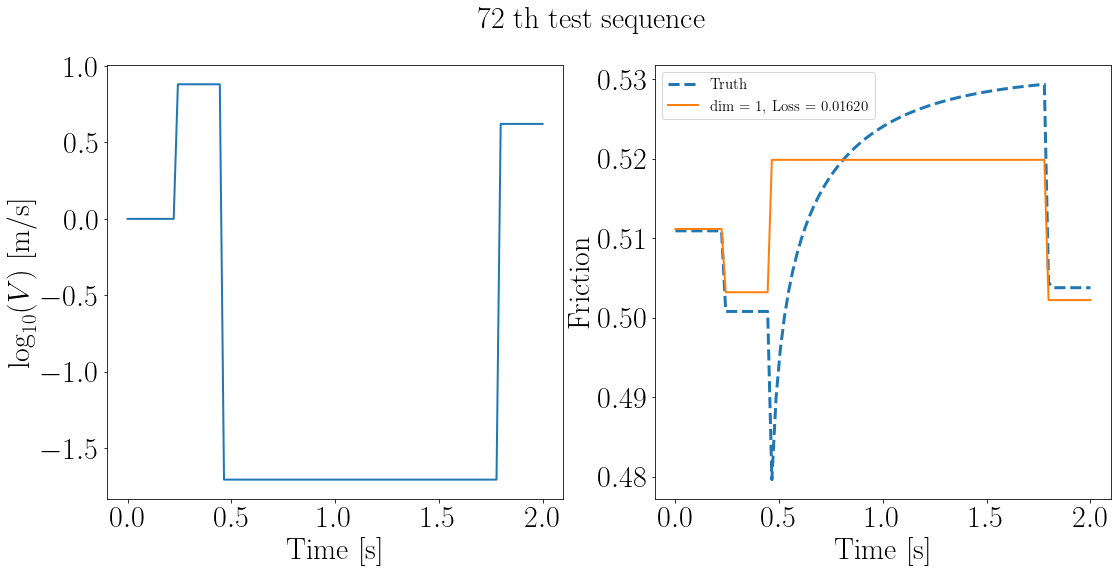

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fsize = 30

# Plot a fitted sequence
def cal_Loss(f, f_targ, t, p=2):
    return torch.pow(
        torch.trapezoid(torch.pow(torch.abs(f - f_targ), p), t) / torch.trapezoid(torch.pow(torch.abs(f_targ), p), t), 
        1./ p
    )

idx = torch.randint(len(testDataset), (1, ))[0]
# idx = 4
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs[0].tick_params(axis='both', which='major', labelsize=fsize)
axs[1].tick_params(axis='both', which='major', labelsize=fsize)

fig.suptitle("{0} th test sequence".format(idx), fontsize=fsize)

axs[0].plot(this_ts[idx, :], torch.log10(this_Vs[idx, :]), linewidth=2.0)
axs[0].set_xlabel("Time [s]", fontsize=fsize)
axs[0].set_ylabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)

axs[1].plot(this_ts[idx, :], this_fs[idx, :], '--', linewidth=3.0, label='Truth')

for dim_xi, this_f_preds_withCorrection in zip(dim_xis, this_f_preds):
    this_loss = cal_Loss(this_f_preds_withCorrection[idx, :], this_fs[idx, :], this_ts[idx, :])
    axs[1].plot(this_ts[idx, :], this_f_preds_withCorrection[idx, :], linewidth=2.0, label='dim = {0}, Loss = {1:.5f}'.format(dim_xi, this_loss))
axs[1].legend(fontsize=15)
# axs[1].set_ylim(0.3, 0.6)
axs[1].set_xlabel("Time [s]", fontsize=fsize)
axs[1].set_ylabel("Friction", fontsize=fsize)

# Model trained on VJump performance on Burigede

In [2]:
# Specify model and datasets
# modelPrefixs = ["Trial0112_smallDRS_smallA", 
#                 "Trial0112_smallDRS_Burigede", 
#                 "Trial0112_combined_resampled", 
#                 "Trial0112_combined", 
#                 "Trial0112_smallA_Burigede", 
#                 "Trial0112_Burigede_smallA", 
#                 "Trial0112_smallA_Burigede_smallA", 
#                 "Trial0112_Burigede_smallA_Burigede", 
#                 ] #, "Trial0112_combined_resampled"]

# legends = ["VJump", "Burigede", "Combined_resampled", "Combined", "V_B", "B_V", "V_B_V", "B_V_B"]

modelPrefixs = ["Trial0216_smallDRS_smallA_400", 
                "Trial0216_smallDRS_Burigede_400", 
                "Trial0112_combined", 
                ] #, "Trial0112_combined_resampled"]

legends = ["VJump", "Burigede", "Combined_resampled"]

# dataPrefix = "Trial0216_smallDRS_Burigede_400"
dataPrefix = "Trial0112_combined"

# Load models and dataset
dataFile = "./data/" + dataPrefix + ".pt"

shit = torch.load(dataFile)
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# If there is an offset applied
manipulateFlag = True
fOffSet = 0.5109
scaling_factor = 50.

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Xs, ts)

# Scale fOffSet
if manipulateFlag:
    fs = (fs - fOffSet) * scaling_factor + fOffSet

# Load dataset 
# Initialize dataloaders
AllData = TensorDataset(
    Xs, 
    Vs, 
    ts, 
    fs
)

dataloader_kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_len = int(len(Vs) * 0.8)
test_len = len(Vs) - train_len

# Created using indices from 0 to train_size.
trainDataset = torch.utils.data.Subset(AllData, range(train_len))

# Created using indices from train_size to train_size + test_size.
testDataset = torch.utils.data.Subset(AllData, range(train_len, train_len + test_len))

# Set testing data loader
testing_batch_size = len(testDataset) # 256
testDataLoader = DataLoader(
    testDataset,
    batch_size = testing_batch_size,
    shuffle = True,
    collate_fn = None,
    **dataloader_kwargs, 
)

In [3]:
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, FricCorrection

# dim_xis = [1, 2, 4, 8]
models = []
dim_xi = 1
for idx, modelPrefix in enumerate(modelPrefixs):
    # model_this = torch.load("./model/" + modelPrefix + "_dimXi_" + str(dim_xi) + "_FG.pth")
    model_this = torch.load("./model/" + modelPrefix + "_dimXi_" + str(dim_xi) + ".pth")
    
    models.append(model_this)
    res_corr = train1Epoch(testDataLoader, Loss, model_this, 2, 0., False).detach()
    print("Test loss with model trained on {0}: ".format(legends[idx]), res_corr)

# Load models one by one
this_Xs = torch.stack([testDataset[i][0] for i in range(len(testDataset))], dim=0)
this_Vs = torch.stack([testDataset[i][1] for i in range(len(testDataset))], dim=0)
this_ts = torch.stack([testDataset[i][2] for i in range(len(testDataset))], dim=0)
this_fs = torch.stack([testDataset[i][3] for i in range(len(testDataset))], dim=0)
this_Xs = this_Xs.to(device)
this_Vs = this_Vs.to(device)
this_ts = this_ts.to(device)
this_fs = this_fs.to(device)

this_f_preds = []
for model_this in models:
    model_this.calf(this_Xs, this_Vs, this_ts)
    this_f_pred = model_this.fs.to("cpu").detach()
    this_f_preds.append(this_f_pred)

this_Xs = this_Xs.to("cpu")
this_Vs = this_Vs.to("cpu")
this_ts = this_ts.to("cpu")
this_fs = this_fs.to("cpu")

# Change the sequences back to their original scaling
if manipulateFlag:
    this_fs = (this_fs - fOffSet) / scaling_factor + fOffSet
    this_f_preds_new = []
    for this_f_pred in this_f_preds:
        this_f_pred = (this_f_pred - fOffSet) / scaling_factor + fOffSet
        this_f_preds_new.append(this_f_pred)

    this_f_preds = [x for x in this_f_preds_new]

Test loss with model trained on VJump:  tensor(0.0379, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with model trained on Burigede:  tensor(0.1702, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with model trained on Combined_resampled:  tensor(0.0276, device='cuda:0', grad_fn=<DivBackward0>)


Text(0, 0.5, 'Friction')

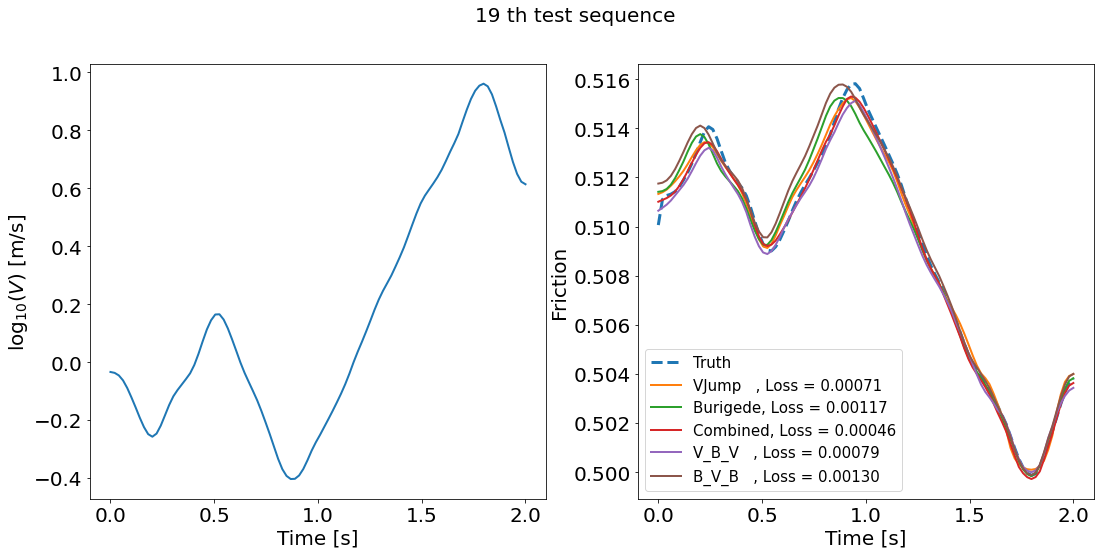

In [29]:
fsize = 20

# Only plot certain lines
# legends = ["VJump", "Burigede", "Combined_resampled", "Combined", "V_B", "B_V", "V_B_V", "B_V_B"]
plotFlags = [True,    True,       False,                True,       False, False, True,    True]

# Plot a fitted sequence
def cal_Loss(f, f_targ, t, p=2):
    return torch.pow(
        torch.trapezoid(torch.pow(torch.abs(f - f_targ), p), t) / torch.trapezoid(torch.pow(torch.abs(f_targ), p), t), 
        1./ p
    )

idx = torch.randint(len(testDataset), (1, ))[0]
idx = 19
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs[0].tick_params(axis='both', which='major', labelsize=fsize)
axs[1].tick_params(axis='both', which='major', labelsize=fsize)

fig.suptitle("{0} th test sequence".format(idx), fontsize=20)

axs[0].plot(this_ts[idx, :], torch.log10(this_Vs[idx, :]), linewidth=2.0)
axs[0].set_xlabel("Time [s]", fontsize=fsize)
axs[0].set_ylabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)

axs[1].plot(this_ts[idx, :], this_fs[idx, :], '--', linewidth=3.0, label='Truth')


for plotFlag, legend, this_f_preds_withCorrection in zip(plotFlags, legends, this_f_preds):
    if plotFlag:
        this_loss = cal_Loss(this_f_preds_withCorrection[idx, :], this_fs[idx, :], this_ts[idx, :])
        axs[1].plot(this_ts[idx, :], this_f_preds_withCorrection[idx, :], linewidth=2.0, label='{0:<8}, Loss = {1:.5f}'.format(legend, this_loss))

axs[1].legend(fontsize=15)
# axs[1].set_ylim(0.3, 0.6)
axs[1].set_xlabel("Time [s]", fontsize=fsize)
axs[1].set_ylabel("Friction", fontsize=fsize)